# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!


In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline
import math ,time

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

            
def draw_solid_lines(img, lines, color=[255, 0, 0], thickness=2):
   # function to draw solid lines for use in 7 images and 2 videos 
######################################################################
# initiate some arrays 
######################################################################
    posSlope=[]
    negSlope=[]
    x1s_pos=[]
    x2s_pos=[]
    y1s_pos=[]
    y2s_pos=[]
    x1s_neg=[]
    x2s_neg=[]
    y1s_neg=[]
    y2s_neg=[]
    
######################################################################    
# loop to draw single lines and caclulate average
######################################################################
    for line in lines:
        for x1,y1,x2,y2 in line:
            a=(y2-y1)/(x2-x1)  # get slope ((y2-y1)/(x2-x1))
#            print (a)  # used once to get slope ranges
            if(a>=0.55 and a<=0.70):
                x1s_pos.append(x1)     # record all x1 points to take averge
                x2s_pos.append(x2)     # record all x2 points to take averge
                y1s_pos.append(y1)     # record all y1 points to take averge
                y2s_pos.append(y2)     # record all y2 points to take averge
                posSlope.append(a)
            elif(a<=-0.65 and  a >=-0.77):
                x1s_neg.append(x1)     # record all x1 points to take averge
                x2s_neg.append(x2)     # record all x2 points to take averge
                y1s_neg.append(y1)     # record all y1 points to take averge
                y2s_neg.append(y2)     # record all y2 points to take averge                
                negSlope.append(a)
            #cv2.line(img, (x1, y1), (x2, y2), color, thickness)  

#    print ( "pos" ,posSlope , "neg" ,negSlope  )
    try:
        avg_x1_pos=np.mean(x1s_pos)     # calculate average of x1 points  
        avg_x2_pos=np.mean(x2s_pos)     # calculate average of x2 points         
        avg_y1_pos=np.mean(y1s_pos)     # calculate average of y1 points         
        avg_y2_pos=np.mean(y2s_pos)     # calculate average of y2 points 

        avg_x1_neg=np.mean(x1s_neg)     # calculate average of x1 points  
        avg_x2_neg=np.mean(x2s_neg)     # calculate average of x2 points         
        avg_y1_neg=np.mean(y1s_neg)     # calculate average of y1 points         
        avg_y2_neg=np.mean(y2s_neg)     # calculate average of y2 points 
        posSlope_avg=np.mean(posSlope)
        negSlope_avg=np.mean(negSlope)
    except ValueError:
        pass
    
######################################################################
# calculate and draw solid line
######################################################################

 # To draw a solid line we should have 2 points (x1,y1) , (x2,y2)
 # slope = ((y2-y1)/(x2-x1))
 # We have an equation of 5 variables , if we have 4 , Calculate the fifth
 # We have average of slopes , average of x , average of y , one y point since we know exactly the y area of interest , 
 #  So we can calculate the corresponding x from the last equation
 # slope = (avg_y1-y1)/(avg_x1-x1)   
 # slope *(avg_x1-x1) = avg_y1-y1 >> (avg_x1-x1)= (avg_y1-y1)/slope >> x1=avg_x1 - (avg_y1-y1)/slope
 # slope *(avg_x2-x2) = avg_y2-y2 >> (avg_x2-x2)= (avg_y2-y2)/slope >> x2=avg_x2 - (avg_y2-y2)/slope
 # Let's set the y area of interest from 330 to 530
 # So we have 4 points (x1_pos,y1_pos) ,x1_neg,y1_neg) ,x2_pos,y2_pos) ,x1_neg,y1_neg)
 # y1_pos = y1_neg = 330 , y2_pos =y2_neg = 530
 # So apply following equation 4 times : x=avg_x - (avg_y-y)/slope
 # Then draw 2 lines . Each line is drawn using 2 points (x corresponding to y1 , y1),(x corresponding to y2 , y2)
    try:
        y1 = 330
        y2 = 530
        x1_pos = avg_x1_pos - (avg_y1_pos-y1)/posSlope_avg
        x2_pos = avg_x2_pos - (avg_y2_pos-y2)/posSlope_avg
        x1_neg = avg_x1_neg - (avg_y1_neg-y1)/negSlope_avg
        x2_neg = avg_x2_neg - (avg_y2_neg-y2)/negSlope_avg
    #    cv2.line(img, (x1_pos, y1), (x2, y2), color, thickness)
        cv2.line(img, (int(x1_pos), y1), (int(x2_pos), y2), [0, 255, 0], 7) 
        cv2.line(img, (int(x1_neg), y1), (int(x2_neg), y2), [0, 255, 0], 7)
    except ValueError:
        pass

    
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_solid_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Show the output of each step in the pipeline



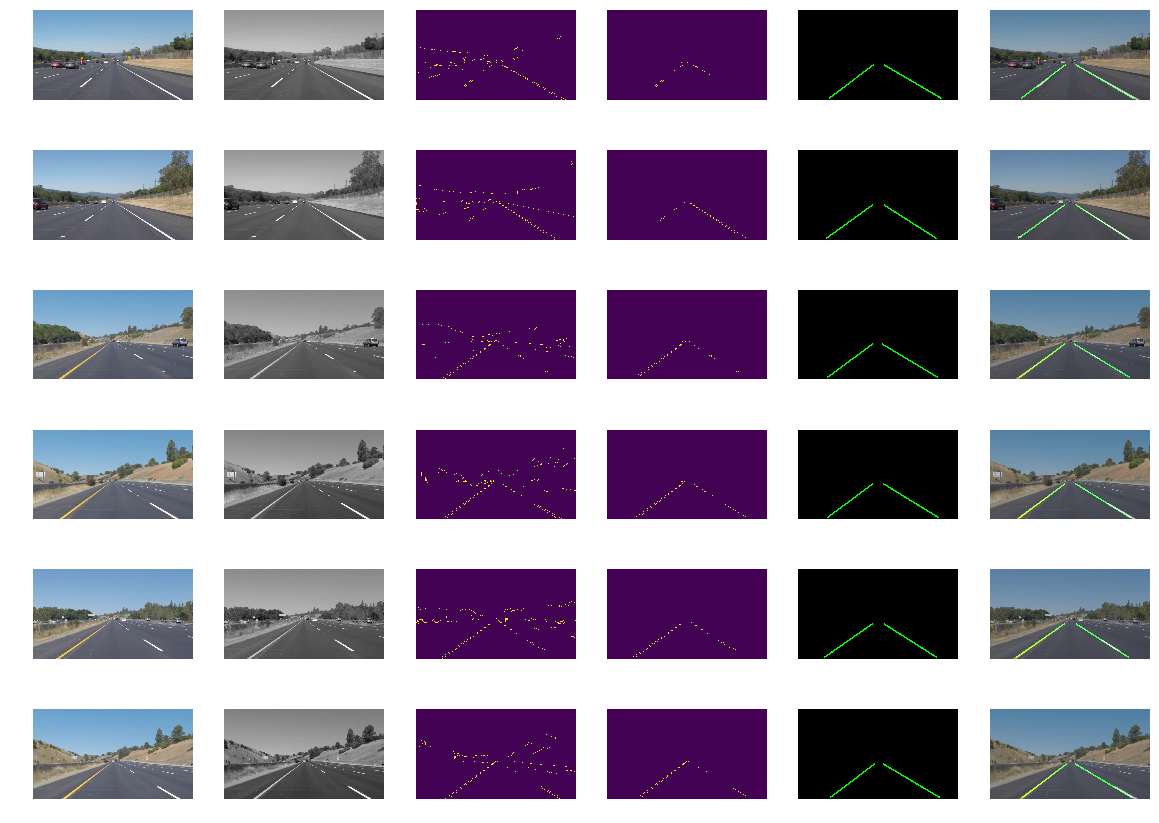

In [2]:
import os ,time
import cv2
from IPython import display
import pylab
pylab.rcParams['figure.figsize'] = (20, 15)

y=os.listdir("test_images/")
x=os.listdir("test_images/")
path_input = 'each_step_output\\0-input_image'
path_gray = 'each_step_output\\1-gray_image'
path_canny = 'each_step_output\\2-canny_image'
path_area = 'each_step_output\\3-area_of_interest'
path_solid = 'each_step_output\\4-solid_lines'
path_final = 'each_step_output\\5-final_images'
kernel_size = 5
low_threshold = 80
high_threshold = 240
vertices = np.array([[(150,530),(450, 310), (490, 310), (850,530)]], dtype=np.int32)
rho = 2 # distance resolution in pixels of the Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
threshold = 50  # minimum number of votes (intersections in Hough grid cell)
min_line_len = 10 #minimum number of pixels making up a line
max_line_gap = 40   # maximum gap in pixels between connectable line segments
#    i=0
for i in range (len(x)):
    x[i]="test_images/"+x[i]
    image = mpimg.imread(x[i])
    plt.subplot(6,6,i*6+1)
    plt.imshow(image)    
#    display.display(plt.gcf())
    plt.axis('off')

    cv2.imwrite(os.path.join(path_input , y[i]), cv2.cvtColor(image, cv2.COLOR_RGB2BGR))

    gray=cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)  
    plt.subplot(6,6,i*6+2)
    plt.imshow(gray,cmap='gray')   
    plt.axis('off')

#    display.display(plt.gcf())
    cv2.imwrite(os.path.join(path_gray , y[i]), gray)

    # Define a kerne size and apply Gaussian smoothing
    blur_gray=cv2.GaussianBlur(gray, (kernel_size, kernel_size), 0)

    # Define our parameters for Canny and apply

    edges=canny(blur_gray, low_threshold, high_threshold)
    plt.subplot(6,6,i*6+3)
    plt.imshow(edges)   
    plt.axis('off')
#    display.display(plt.gcf())
    cv2.imwrite(os.path.join(path_canny , y[i]), edges)


    # Next we'll create a masked edges image using cv2.fillPoly()
    imshape = image.shape
    # This time we are defining a four sided polygon to mask
    masked_edges = region_of_interest(edges, vertices)
    plt.subplot(6,6,i*6+4)
    plt.imshow(masked_edges) 
    plt.axis('off')
#    display.display(plt.gcf())
    cv2.imwrite(os.path.join(path_area , y[i]), masked_edges)

    # Define the Hough transform parameters
    line_image = np.copy(image) # creating a blank to draw lines on
    # Run Hough on edge detected image
    # Output "lines" is an array containing endpoints of detected line segments
    line_image = hough_lines(masked_edges, rho, theta, threshold, min_line_len, max_line_gap)
    #plt.imshow(line_image)
    plt.subplot(6,6,i*6+5)
    plt.imshow(line_image)  
    plt.axis('off')
#    display.display(plt.gcf())
    cv2.imwrite(os.path.join(path_solid , y[i]), line_image)

    # Draw the lines on the edge image
    
    lines_edges = cv2.addWeighted(image, 0.8, line_image, 3, 0)
    plt.subplot(6,6,i*6+6)
    plt.imshow(lines_edges) 
    plt.axis('off')
    cv2.imwrite(os.path.join(path_final , y[i]), cv2.cvtColor(lines_edges, cv2.COLOR_RGB2BGR))




## Test on Videos and a set of images


In [3]:
# MAIN FUNCTION

 #Function process_image() is the pipeline used to draw solid lines 
 #in each image in the 7 images or in the frames of the 2 videos.

 #1- import some libraries for displaying purposes.
 #2- Fine tune parameters that set grayscale , canny algorism , hough lines  and Area of interest
 #3- Applying The pipline to the input image:
 #   a- Convert RGB image to a grayscale image
 #   b- Apply a Gaussian blur to the grayscale image
 #   c- Use a Canny transformation to find edges on the blured image
 #   d- Set the area of interest to only the area we are interested in.
 #    -( This should differ from vedio size/camera position to another  )
 #   e- Use hough_lines function to find lines from the edges only 
 #      in our area of interest and use these lines to draw only 2 solid lines
 #      that represents all lanelines 
 #  f- Now we have an image of only lines . Draw these lines in the 
 #     original RGB image using weighted_img function
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from IPython import display
import os
os.listdir("test_images/")
def process_image(image):

    kernel_size = 5 #for Gaussian smoothing

    # Define our parameters for Canny
    low_threshold = 80   # Algorithm neglect all edges below this number.
    high_threshold = 240 # Algorithm detects :
                         # -strong edges above this number
                         # -between the two numbers only if they are connected to strong edges

    # Define the Hough transform parameters
    rho = 2 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 50   # minimum number of votes (intersections in Hough grid cell)
    min_line_len = 10 #minimum number of pixels making up a line
    max_line_gap = 40   # maximum gap in pixels between connectable line segments
    line_image = np.copy(image) # creating a blank to draw lines on
    vertices = np.array([[(130,500),(450, 310), (470, 310), (900,500)]], dtype=np.int32)

    gray=grayscale(image)  #Convert RGB image to a grayscale image
    blur_gray=gaussian_blur(gray, kernel_size)  # Apply a Gaussian blur to the grayscale image
    edges=canny(blur_gray, low_threshold, high_threshold)  # Use a Canny transformation to find edges on the blured image
    masked_edges = region_of_interest(edges, vertices)  #Set the area of interest to only the area we are interested in.
    line_image = hough_lines(masked_edges, rho, theta, threshold, min_line_len, max_line_gap) 
    # Find lines from the edges and use these lines to draw only 2 solid lines that represents all lanelines
    weighted = weighted_img(line_image, image,0.8,3.0,0.0)  #D raw lines in the original RGB image
    return weighted



['solidWhiteCurve.jpg', 'solidWhiteRight.jpg', 'solidYellowCurve.jpg', 'solidYellowCurve2.jpg', 'solidYellowLeft.jpg', 'whiteCarLaneSwitch.jpg']


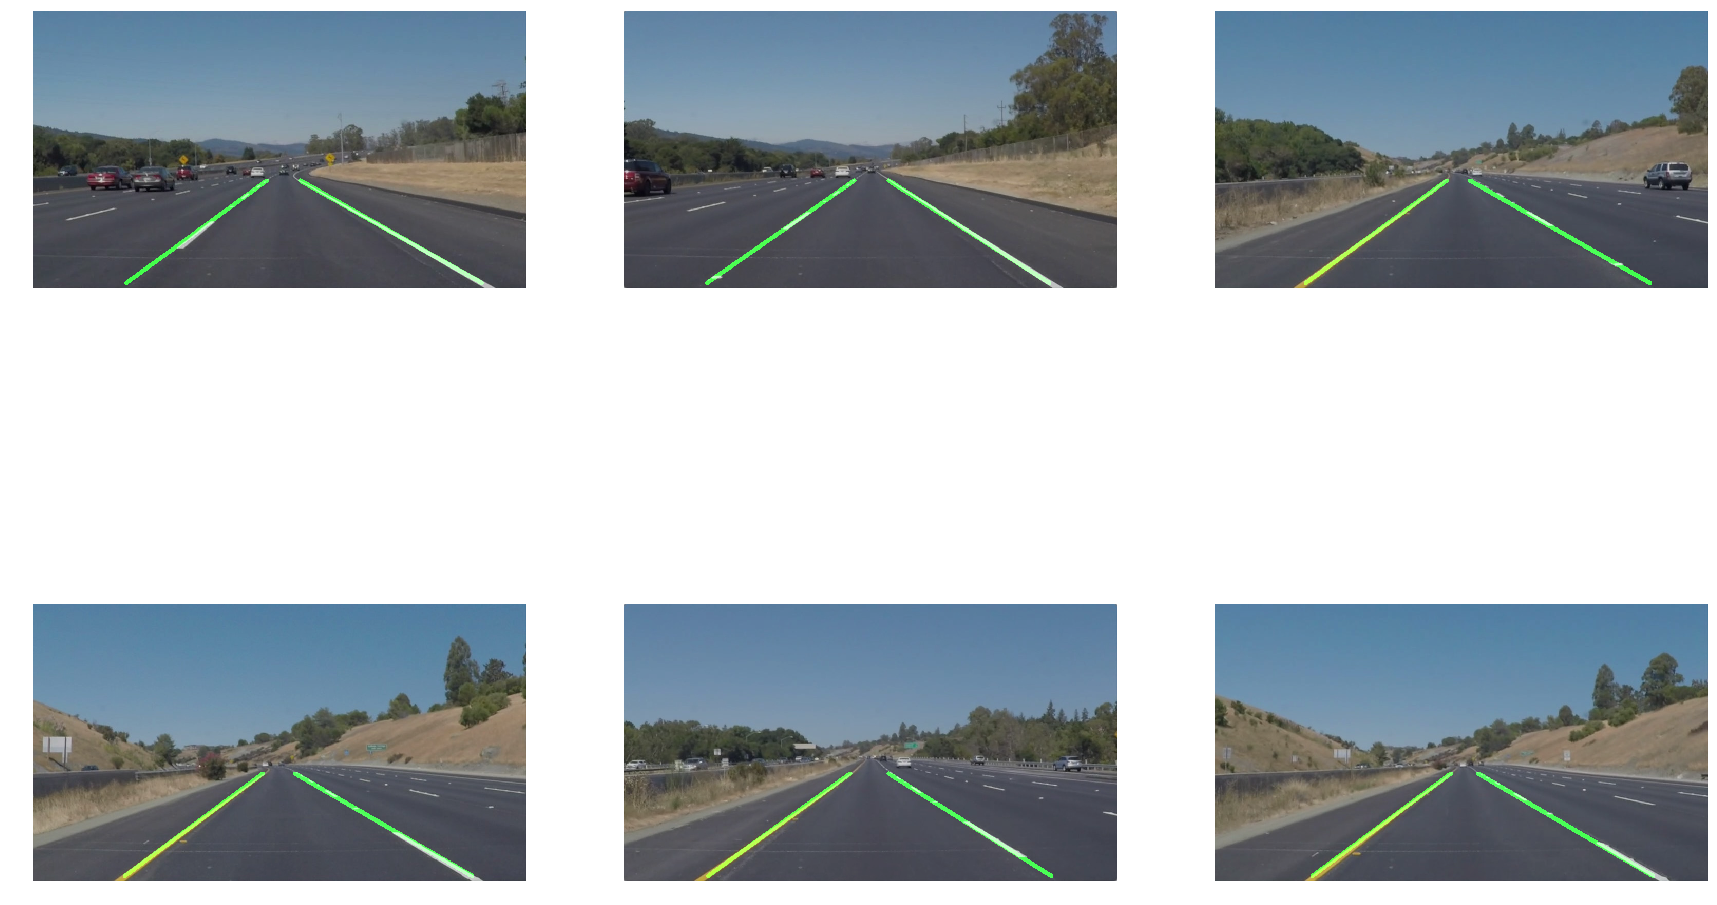

In [4]:
# Apply the pipeline to a set of images

import os ,time
from IPython import display
import pylab
pylab.rcParams['figure.figsize'] = (30, 20)
x=os.listdir("test_images/")
y=os.listdir("test_images/")

print (x)
for i in range(0,len(x)):
    x[i]="test_images/"+x[i]
    image = mpimg.imread(x[i])
    lines_edges=process_image(image)
    plt.subplot(2,3,i+1)
    plt.imshow(lines_edges)
    plt.axis('off')
#    display.display(plt.gcf())
    path = 'test_images_output'
    cv2.imwrite(os.path.join(path , y[i]), cv2.cvtColor(lines_edges, cv2.COLOR_RGB2BGR))
 #   display.clear_output(wait=True)

In [5]:
# Apply the pipeline to solidWhiteRight video


white_output = 'test_videos_output/solidWhiteRight.mp4'
clip = VideoFileClip("test_videos/solidWhiteRight.mp4")

#print("before pipeline")
white_clip = clip.fl_image(process_image) #NOTE: this function expects color images!!
#print("after pipeline")
%time white_clip.write_videofile(white_output, audio=False)
#print("Finished")


[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|███████████████████████████████████████████████████████████████████████████████▋| 221/222 [00:09<00:00, 22.45it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

Wall time: 11.6 s


In [6]:
# Show video on screen
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [7]:
# Apply the pipeline to solidYellowLeft video

white_output = 'test_videos_output/solidYellowLeft.mp4'

clip = VideoFileClip("test_videos/solidYellowLeft.mp4")

#print("before pipeline")
white_clip = clip.fl_image(process_image) #NOTE: this function expects color images!!
#print("after pipeline")
%time white_clip.write_videofile(white_output, audio=False)
#print("Finished")

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|███████████████████████████████████████████████████████████████████████████████▉| 681/682 [00:35<00:00, 19.13it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

Wall time: 37.8 s


In [8]:
# Show video on screen
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

# Challenge 
Please Kernal > restart & Clear output to execute the challenge


## Helper Functions for challenge video


In [9]:
def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

## Determining region of interest

Take an image from the video and use it to determine the proper region of interest in this video


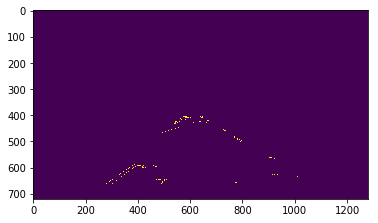

In [10]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline
import math ,time
from IPython import display
image = mpimg.imread('test_image_challenge/challenge_example3.jpg')
gray=cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
kernel_size = 5
blur_gray=cv2.GaussianBlur(gray, (kernel_size, kernel_size), 0)
low_threshold = 20
high_threshold = 240
#    plt.imshow(blur_gray)
edges=canny(blur_gray, low_threshold, high_threshold)
vertices = np.array([[(190,660),(580, 400), (640, 400), (1100,660)]], dtype=np.int32)
masked_edges = region_of_interest(edges, vertices)
plt.imshow(masked_edges)
time.sleep(0.5)

## Functions for challenge video

Since the challenge video has different region of interest . so It has different area of y and different slopes

So it should have its specific functions


In [11]:
def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)


def draw_challenge_lines(img, lines, color=[255, 0, 0], thickness=2):
   # function to draw solid lines for use in 7 images and 2 videos 
######################################################################
# initiate some arrays 
######################################################################
    posSlope=[]
    negSlope=[]
    x1s_pos=[]
    x2s_pos=[]
    y1s_pos=[]
    y2s_pos=[]
    x1s_neg=[]
    x2s_neg=[]
    y1s_neg=[]
    y2s_neg=[]
    
######################################################################    
# loop to draw single lines and caclulate average
######################################################################
    for line in lines:
        for x1,y1,x2,y2 in line:
            a=(y2-y1)/(x2-x1)  # get slope ((y2-y1)/(x2-x1))
 #           print (a)  # used once to get slope ranges
            if(a>=0.60 and a<=0.75):
                x1s_pos.append(x1)     # record all x1 points to take averge
                x2s_pos.append(x2)     # record all x2 points to take averge
                y1s_pos.append(y1)     # record all y1 points to take averge
                y2s_pos.append(y2)     # record all y2 points to take averge
                posSlope.append(a)
            elif(a<=-0.61 and  a >=-0.73):
                x1s_neg.append(x1)     # record all x1 points to take averge
                x2s_neg.append(x2)     # record all x2 points to take averge
                y1s_neg.append(y1)     # record all y1 points to take averge
                y2s_neg.append(y2)     # record all y2 points to take averge                
                negSlope.append(a)
 #           cv2.line(img, (x1, y1), (x2, y2), color, thickness)  

#    print ( "pos" ,posSlope , "neg" ,negSlope  )
    try:
        avg_x1_pos=np.mean(x1s_pos)     # calculate average of x1 points  
        avg_x2_pos=np.mean(x2s_pos)     # calculate average of x2 points         
        avg_y1_pos=np.mean(y1s_pos)     # calculate average of y1 points         
        avg_y2_pos=np.mean(y2s_pos)     # calculate average of y2 points 

        avg_x1_neg=np.mean(x1s_neg)     # calculate average of x1 points  
        avg_x2_neg=np.mean(x2s_neg)     # calculate average of x2 points         
        avg_y1_neg=np.mean(y1s_neg)     # calculate average of y1 points         
        avg_y2_neg=np.mean(y2s_neg)     # calculate average of y2 points 
        posSlope_avg=np.mean(posSlope)
        negSlope_avg=np.mean(negSlope)
    except ValueError:
        pass
    
######################################################################
# calculate and draw solid line
######################################################################

 # To draw a solid line we should have 2 points (x1,y1) , (x2,y2)
 # slope = ((y2-y1)/(x2-x1))
 # We have an equation of 5 variables , if we have 4 , Calculate the fifth
 # We have average of slopes , average of x , average of y , one y point since we know exactly the y area of interest , 
 #  So we can calculate the corresponding x from the last equation
 # slope = (avg_y1-y1)/(avg_x1-x1)   
 # slope *(avg_x1-x1) = avg_y1-y1 >> (avg_x1-x1)= (avg_y1-y1)/slope >> x1=avg_x1 - (avg_y1-y1)/slope
 # slope *(avg_x2-x2) = avg_y2-y2 >> (avg_x2-x2)= (avg_y2-y2)/slope >> x2=avg_x2 - (avg_y2-y2)/slope
 # Let's set the y area of interest from 350 to 530
 # So we have 4 points (x1_pos,y1_pos) ,x1_neg,y1_neg) ,x2_pos,y2_pos) ,x1_neg,y1_neg)
 # y1_pos = y1_neg = 720 , y2_pos =y2_neg = 450
 # So apply following equation 4 times : x=avg_x - (avg_y-y)/slope
 # Then draw 2 lines . Each line is drawn using 2 points (x corresponding to y1 , y1),(x corresponding to y2 , y2)
    try:
        y1 = 680
        y2 = 450
        x1_pos = avg_x1_pos - (avg_y1_pos-y1)/posSlope_avg
        x2_pos = avg_x2_pos - (avg_y2_pos-y2)/posSlope_avg
        x1_neg = avg_x1_neg - (avg_y1_neg-y1)/negSlope_avg
        x2_neg = avg_x2_neg - (avg_y2_neg-y2)/negSlope_avg
    #    cv2.line(img, (x1_pos, y1), (x2, y2), color, thickness)
        cv2.line(img, (int(x1_pos), y1), (int(x2_pos), y2), [0, 255, 0], 7) 
        cv2.line(img, (int(x1_neg), y1), (int(x2_neg), y2), [0, 255, 0], 7)
    except ValueError:
        pass

    
def hough_challenge(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_challenge_lines(line_img, lines)
    return line_img

## Main function for challenge video


In [12]:
# MAIN FUNCTION

 #Function process_image_challenge() is the pipeline used to draw solid lines 
 #in each image in the 7 images or in the frames of the 2 videos.

 #1- import some libraries for displaying purposes.
 #2- Fine tune parameters that set grayscale , canny algorism , hough lines  and Area of interest
 #3- Applying The pipline to the input image:
 #   a- Convert RGB image to a grayscale image
 #   b- Apply a Gaussian blur to the grayscale image
 #   c- Use a Canny transformation to find edges on the blured image
 #   d- Set the area of interest to only the area we are interested in.
 #    -( This should differ from vedio size/camera position to another  )
 #   e- Use hough_lines function to find lines from the edges only 
 #      in our area of interest and use these lines to draw only 2 solid lines
 #      that represents all lanelines 
 #  f- Now we have an image of only lines . Draw these lines in the 
 #     original RGB image using weighted_img function
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from IPython import display
import os
os.listdir("test_images/")
def process_image_challenge (image):
    kernel_size = 5 #for Gaussian smoothing

    # Define our parameters for Canny
    low_threshold = 80   # Algorithm neglect all edges below this number.
    high_threshold = 240 # Algorithm detects :
                         # -strong edges above this number
                         # -between the two numbers only if they are connected to strong edges

    # Define the Hough transform parameters
    rho = 2 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 50   # minimum number of votes (intersections in Hough grid cell)
    min_line_len = 5 #minimum number of pixels making up a line
    max_line_gap = 40   # maximum gap in pixels between connectable line segments
    line_image = np.copy(image) # creating a blank to draw lines on
    vertices = np.array([[(190,680),(580, 400), (640, 400), (1100,680)]], dtype=np.int32)
    gray=grayscale(image)  #Convert RGB image to a grayscale image
    blur_gray=gaussian_blur(gray, kernel_size)  # Apply a Gaussian blur to the grayscale image
    edges=canny(blur_gray, low_threshold, high_threshold)  # Use a Canny transformation to find edges on the blured image
    masked_edges = region_of_interest(edges, vertices)  #Set the area of interest to only the area we are interested in.
    line_image = hough_challenge(masked_edges, rho, theta, threshold, min_line_len, max_line_gap) 
    # Find lines from the edges and use these lines to draw only 2 solid lines that represents all lanelines
    weighted = weighted_img(line_image, image,0.8,3.0,0.0)  #D raw lines in the original RGB image
    return weighted

In [13]:
challenge_output = 'test_videos_output/challenge.mp4'
clip = VideoFileClip("test_videos/challenge.mp4")
challenge_clip = clip.fl_image(process_image_challenge)
%time challenge_clip.write_videofile(challenge_output, audio=False)

OSError: [WinError 6] The handle is invalid

In [ ]:
# Show video on screen
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))